In [155]:
import gpytorch
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [156]:
# settings
in_path = 'data/'
out_path = 'data/heatmaps/'

# pollutants = ['NO2', 'NOx', 'PM2.5', 'PM10']
pollutants = ['NOx']

num_tasks = 1
training_iterations = 100

lat_bounds = [44.45, 46.65]
lon_bounds = [8.20 , 12.15]

resolution = 100

download = True
verbose = True

In [157]:
def features(pollutant):
    return [pollutant + '_2019', pollutant + '_2020']

In [158]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=num_tasks
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.MaternKernel(), num_tasks=num_tasks, rank=num_tasks
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [159]:
def fit_and_predict(train_x, train_y, num_tasks, training_iterations, lats, lons):

    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks)

    model = MultitaskGPModel(train_x, train_y, likelihood)

    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam([{'params': model.parameters()},], lr=0.05)

    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
    
    grid = [ (lat, lon) for lat in lats for lon in lons]

    grid_x = torch.from_numpy(np.array(grid)).float()

    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():

        predictions = likelihood(model(grid_x))
        mean = predictions.mean
        lower, upper = predictions.confidence_region()

    print(len(mean))
    
    return mean

In [160]:
def normalize(df, feature1, feature2, verbose=False, output=None):

    min_value_1 = df[feature1].min()
    max_value_1 = df[feature1].max()
    min_value_2 = df[feature2].min()
    max_value_2 = df[feature2].max()

    max_value = max_value_1 if max_value_1 > max_value_2 else max_value_2
    min_value = min_value_1 if min_value_1 < min_value_2 else min_value_2

    if verbose:
        print('\n' + feature1 + '\n')
        print('Min: {}, Max: {}\n'.format(min_value_1, max_value_1))

        print('\n' + feature2 + '\n')
        print('Min: {}, Max: {}\n'.format(min_value_2, max_value_2))
    
    if output:
        output.write('\n' + feature1 + '\n')
        output.write('Min: {}, Max: {}\n'.format(min_value_1, max_value_1))

        output.write('\n' + feature2 + '\n')
        output.write('Min: {}, Max: {}\n'.format(min_value_2, max_value_2))
    
    normalized = df[feature2].copy()
    
    df[feature1 + '_Norm'] = df[feature1] / max_value     
 
    df[feature2 + '_Norm'] = normalized / max_value 

    if verbose: print(df.head(3))

    return df

NOx_2019
10000


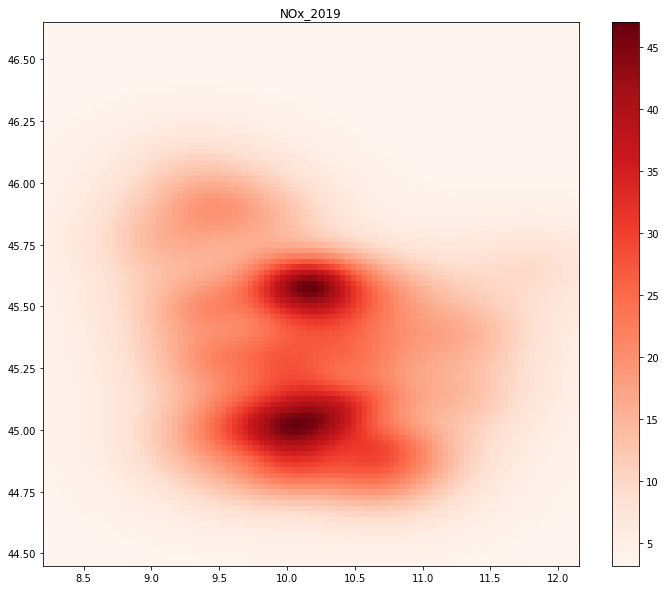

NOx_2020
10000


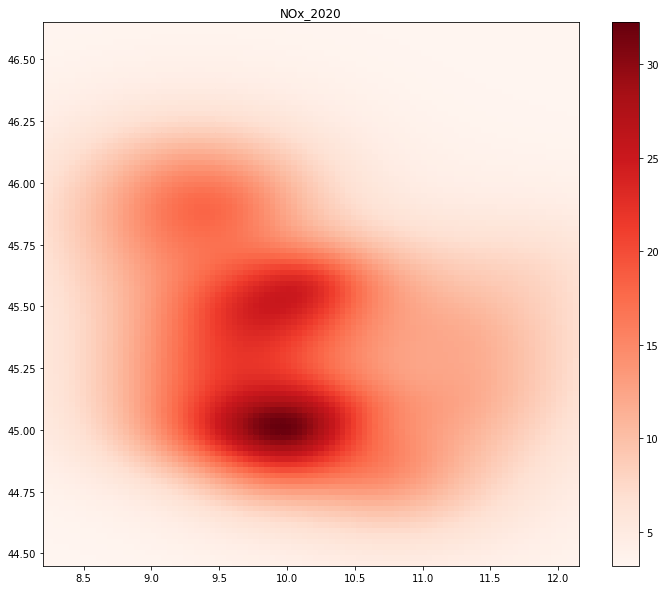


NOx_2019

Min: 3.1764121055603027, Max: 47.039939880371094


NOx_2020

Min: 3.1737258434295654, Max: 32.256256103515625

    Latitude  Longitude  NOx_2019  NOx_2020  NOx_2019_Norm  NOx_2020_Norm
0  44.450001   8.200000  3.220538  3.208220       0.068464       0.068202
1  44.450001   8.239899  3.230754  3.220516       0.068681       0.068463
2  44.450001   8.279798  3.242926  3.235754       0.068940       0.068787
    Latitude  Longitude  NOx_2019  NOx_2020  NOx_2019_Norm  NOx_2020_Norm
0  44.450001   8.200000  3.220538  3.208220       0.068464       0.068202
1  44.450001   8.239899  3.230754  3.220516       0.068681       0.068463
2  44.450001   8.279798  3.242926  3.235754       0.068940       0.068787
3  44.450001   8.319697  3.257306  3.254507       0.069246       0.069186
4  44.450001   8.359596  3.274139  3.277422       0.069603       0.069673


In [161]:
with open('./data/report_estimate.txt', 'w') as f:

    for pollutant in pollutants:

        data = pd.read_csv(in_path + pollutant + '.csv')

        coords = [(lat, lon) for (lat, lon) in zip(data['Latitude'], data['Longitude'])]

        train_x = torch.from_numpy(np.asarray(coords)).float()   

        lats = np.linspace(lat_bounds[0], lat_bounds[1], resolution)
        lons = np.linspace(lon_bounds[0], lon_bounds[1], resolution)
        grid = [ (lat, lon) for lat in lats for lon in lons]

        grid_x = torch.from_numpy(np.array(grid)).float()

        hm = pd.DataFrame({'Latitude': np.array(grid_x[:, 0]), 'Longitude': np.array(grid_x[:, 1]) })

        for ds in features(pollutant):

            print(ds)

            train_y = torch.from_numpy(np.asarray(data[ds])).unsqueeze(1).float()

            predictions = fit_and_predict(train_x, train_y, 1, training_iterations, lats=lats, lons=lons)

            grid_lats, grid_lons = np.meshgrid(lats, lons)

            grid_values = predictions.reshape(resolution, resolution)
            grid_values = grid_values[:-1, :-1]
            l_a = grid_lons.min()
            r_a = grid_lons.max()
            l_b = grid_lats.min()
            r_b = grid_lats.max()
            l_c, r_c  = np.abs(grid_values).min(), np.abs(grid_values).max()

            figure, axs = plt.subplots(figsize=(12, 10))

            graph = axs.pcolormesh(grid_lons, grid_lats, grid_values, cmap='Reds', vmin=l_c, vmax=r_c)
            axs.set_title(ds)
            axs.axis([l_a, r_a, l_b, r_b])
            figure.colorbar(graph)

            plt.show()

            hm[ds] = np.array(predictions.squeeze())
        

        hm = normalize(hm, pollutant + '_2019', pollutant + '_2020', verbose=True, output=f)  

        print(hm.head())     

    # heatmap.to_csv(out_path + ds + '.csv')

In [162]:
hm['NOx_2019_Norm'].max(), hm['NOx_2020_Norm'].max(), hm['NOx_2019'].max(), hm['NOx_2020'].max()

(1.0, 0.6857206, 47.03994, 32.256256)

In [163]:
hm.to_csv('./data/heatmaps/NOx_estimated.csv')